In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
import pandas as pd

In [21]:
df_bon=pd.read_csv('Donnees_Vols_BON_F_2.csv')
df_mauvais=pd.read_csv('Donnees_Vols_RA_2.csv')

In [22]:
df_merge = pd.concat([df_bon, df_mauvais], ignore_index=True)
df_merge.shape
df_merge.describe()
df_merge=df_merge.drop(columns=['erreur_m'])

In [23]:
df_merge.shape

(11970, 22)

In [24]:
X=df_merge.drop(columns=['is_attack','snow'],axis=1)
Y=df_merge['is_attack']

In [25]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import tensorflow as tf

# Ta couche personnalisée (inchangée)
class ScaledActivatedDense(Layer):
    def __init__(self, units, activation='relu', name_prefix="", **kwargs):
        super(ScaledActivatedDense, self).__init__(**kwargs)
        self.units = units
        self.activation_fn = tf.keras.activations.get(activation)
        self.name_prefix = name_prefix

    def build(self, input_shape):
        self.dense = Dense(self.units, activation=None, use_bias=True)
        self.a = self.add_weight(
            name=f"{self.name_prefix}_scales",
            shape=(self.units,),
            initializer="ones",
            trainable=True
        )

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.activation_fn(x)
        return self.a * x


In [29]:

timesteps = 3
features_per_step = 20
input_layer = Input(shape=(timesteps, features_per_step), name="input")

# Étape 1 : réduire par moyenne globale les 3 pas de temps
x = GlobalAveragePooling1D()(input_layer)  # devient (batch_size, features_per_step)

# Étape 2 : MLP profond
x = BatchNormalization()(x)
x = ScaledActivatedDense(64, activation='relu', name_prefix="dense1")(x)
x = Dropout(0.3)(x)

x = ScaledActivatedDense(32, activation='relu', name_prefix="dense2")(x)
x = Dropout(0.3)(x)

x = ScaledActivatedDense(16, activation='relu', name_prefix="dense3")(x)

# Sortie
output = Dense(1, activation='sigmoid', name="output")(x)

# Création du modèle
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()   

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 3, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 20)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_activated_dense_9        │ (None, 64)             │         1,408 │
│ (ScaledActivatedDense)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_activated_dense_10       │ (None, 32)             │         2,112 │
│ (ScaledActivatedDense)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ scaled_activated_dense_11       │ (None, 16)             │           544 │
│ (ScaledActivatedDense)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161 (16.25 KB)

 Trainable params: 4,121 (16.10 KB)

 Non-trainable params: 40 (160.00 B)

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [31]:
X = X_scaled.to_numpy()[:3990* 3].reshape(3990, 3, 20)
print(X)

[[[-1.43166288  0.64074356 -0.12596768 ... -0.20437252 -0.47420708
   -1.446373  ]
  [-1.43166288  0.64074356 -0.09005857 ... -0.20437252 -0.47420708
   -1.446373  ]
  [-1.43166288  0.64074356 -0.06401556 ... -0.20437252 -0.47420708
   -1.446373  ]]

 [[-1.43166288  0.64074356 -0.02337534 ... -0.20437252 -0.47420708
   -1.446373  ]
  [-1.43166288  0.64074357  0.00569846 ... -0.20437252 -0.47420708
   -1.446373  ]
  [-1.43166288  0.64074357  0.0417222  ... -0.20437252 -0.47420708
   -1.446373  ]]

 [[-1.43166288  0.64074357  0.07346234 ... -0.20437252 -0.47420708
   -1.446373  ]
  [-1.43166288  0.64074358  0.10882782 ... -0.20437252 -0.47420708
   -1.446373  ]
  [-1.43166288  0.64074358  0.14309075 ... -0.20437252 -0.47420708
   -1.446373  ]]

 ...

 [[ 0.33743564  0.64129713  0.21554522 ... -0.20457974 -0.11805972
    0.39769247]
  [ 0.33743564  0.64129713  0.21156424 ... -0.20457974 -0.11805972
    0.39769247]
  [ 0.33743564  0.64129713  0.20686323 ... -0.20457974 -0.11805972
    0.39

In [32]:
nb_lignes = len(Y)
vol_length = 3
nb_vols = nb_lignes // vol_length
y = Y.to_numpy().reshape(nb_vols, 3)
y_vol = y[:, 0:1]
print(y_vol.shape)

(3990, 1)


In [33]:
y = y_vol.reshape(-1, 1)
print(X.shape)


(3990, 3, 20)


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
import time
sart_time = time.time()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)
end_time = time.time()


loss, accuracy = model.evaluate(X_test, y_test)
print("Training time : ",end_time - sart_time)

Epoch 1/100


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7072 - loss: 0.5595 - val_accuracy: 0.8451 - val_loss: 0.3102
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8595 - loss: 0.3249 - val_accuracy: 0.8560 - val_loss: 0.2871
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8647 - loss: 0.3055 - val_accuracy: 0.8670 - val_loss: 0.2782
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8797 - loss: 0.2853 - val_accuracy: 0.8779 - val_loss: 0.2685
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8694 - loss: 0.2791 - val_accuracy: 0.8607 - val_loss: 0.2699
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8756 - loss: 0.2707 - val_accuracy: 0.8826 - val_loss: 0.2551
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8923 - loss: 0.2412 - val_accuracy: 0.8764 - val_loss: 0.2491
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8746 - loss: 0.2578 - val_accuracy: 0.8858 - val_loss: 0.2

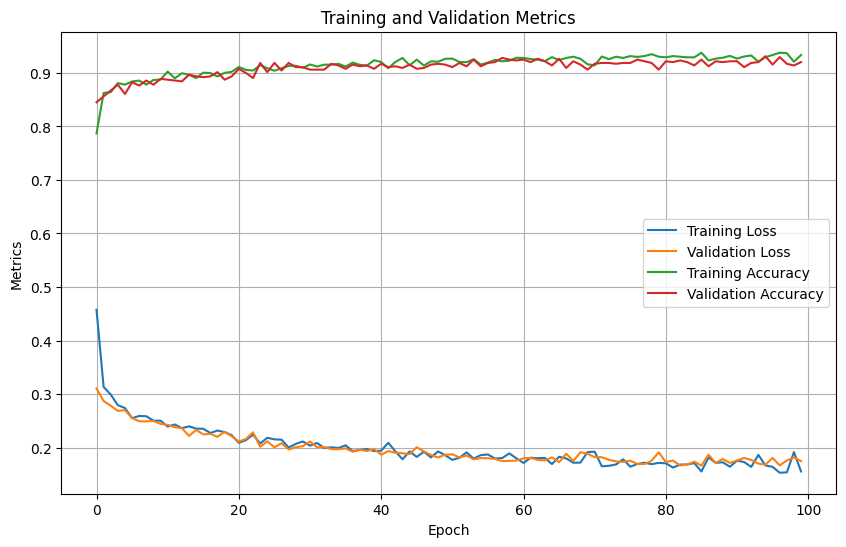

In [36]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Sequential
model2 = Sequential([
    LSTM(units=14, input_shape=(3, 20), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(units=7, return_sequences=False),
    Dropout(0.3),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

sart_time = time.time()
history = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

end_time = time.time()


loss, accuracy = model2.evaluate(X_test, y_test)
print("Training time : ",end_time - sart_time)

Epoch 1/100


c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6447 - loss: 0.6571 - val_accuracy: 0.8247 - val_loss: 0.5121
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8481 - loss: 0.3533 - val_accuracy: 0.8498 - val_loss: 0.3810
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8496 - loss: 0.3410 - val_accuracy: 0.8623 - val_loss: 0.3135
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8634 - loss: 0.3132 - val_accuracy: 0.8654 - val_loss: 0.2889
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8596 - loss: 0.3251 - val_accuracy: 0.8670 - val_loss: 0.2749
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8631 - loss: 0.3067 - val_accuracy: 0.8748 - val_loss: 0.2615
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8928 - loss: 0.2743 - val_accuracy: 0.8779 - val_loss: 0.2558
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8664 - loss: 0.2937 - val_accuracy: 0.8795 - val_loss: 0.

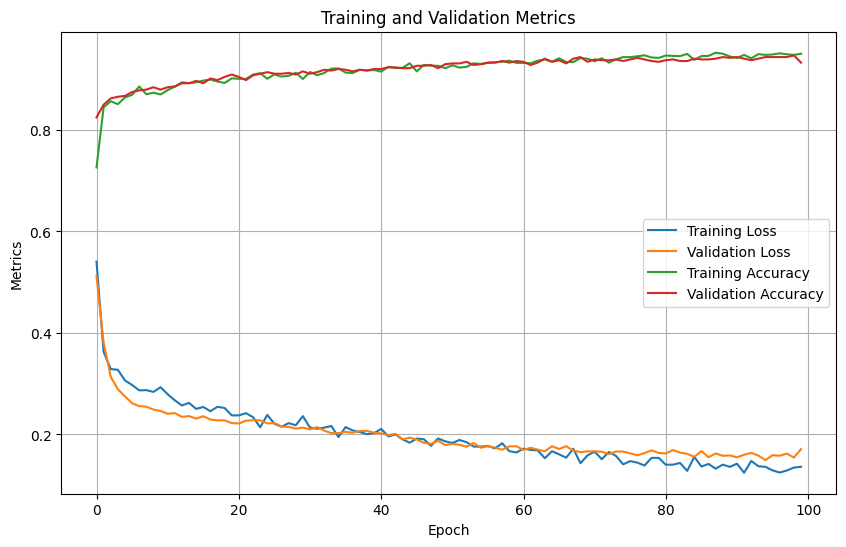

In [38]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
from tensorflow.keras.layers import Layer, ReLU

class ScaledReLU(Layer):
    def __init__(self, name_prefix, **kwargs):
        super(ScaledReLU, self).__init__(**kwargs)
        self.name_prefix = name_prefix
        self.relu = ReLU()

    def build(self, input_shape):
        self.a = self.add_weight(name=f"{self.name_prefix}_a",
                                 shape=(),
                                 initializer="ones",
                                 trainable=True)

    def call(self, inputs):
        return self.a * self.relu(inputs)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model

# Hypothèses
timesteps = 3        # 21 étapes temporelles
features_per_step = 20 

features_input = Input(shape=(timesteps, features_per_step), name='X')


activation = Lambda(lambda x: tf.zeros_like(x[:, :1,0]))(features_input)
a = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32, name="learnable_scalar")
print(activation.shape)
activations=[]
# Boucle manuelle sur les 21 steps
for t in range(timesteps):
    step_features = Lambda(lambda x: x[:, t])(features_input) 
    combined_input = Concatenate(axis=1)([step_features, activation])  # (batch_size, 18+1)
    
    # Passer par une couche dense = "neurone" personnalisé
    neuron_output = Dense(1, activation='sigmoid', name=f'neuron_{t+1}')(combined_input)
    scaled_relu = ScaledReLU(name_prefix=f't{t+1}')(neuron_output)
    activation = scaled_relu
    activations.append(scaled_relu)

    #activation = Lambda(lambda x: tf.expand_dims(x, axis=1))(neuron_output) 
   
    
    

final_output = Dense(1, activation='sigmoid')(activation)

# Construction du modèle
model3 = Model(inputs=features_input, outputs=final_output)

# Compilation
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # regression : MSE/MAE

# Résumé du modèle
model3.summary()

(None, 1)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ X (InputLayer)      │ (None, 3, 20)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 20)        │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 21)        │          0 │ lambda_5[0][0],   │
│ (Concatenate)       │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neuron_1 (Dense)    │ (None, 1)         │         22 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 20)        │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_re_lu_3      │ (None, 1)         │          1 │ neuron_1[0][0]    │
│ (ScaledReLU)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 21)        │          0 │ lambda_6[0][0],   │
│ (Concatenate)       │                   │            │ scaled_re_lu_3[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neuron_2 (Dense)    │ (None, 1)         │         22 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 20)        │          0 │ X[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_re_lu_4      │ (None, 1)         │          1 │ neuron_2[0][0]    │
│ (ScaledReLU)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 21)        │          0 │ lambda_7[0][0],   │
│ (Concatenate)       │                   │            │ scaled_re_lu_4[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neuron_3 (Dense)    │ (None, 1)         │         22 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaled_re_lu_5      │ (None, 1)         │          1 │ neuron_3[0][0]    │
│ (ScaledReLU)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │          2 │ scaled_re_lu_5[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:
sart_time = time.time()
history = model3.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

end_time = time.time()


loss, accuracy = model2.evaluate(X_test, y_test)
print("Training time : ",end_time - sart_time)

Epoch 1/100


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8956 - loss: 0.2560 - val_accuracy: 0.8858 - val_loss: 0.2787
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9040 - loss: 0.2455 - val_accuracy: 0.8889 - val_loss: 0.2788
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - loss: 0.2557 - val_accuracy: 0.8905 - val_loss: 0.2778
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8976 - loss: 0.2518 - val_accuracy: 0.8858 - val_loss: 0.2779
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8880 - loss: 0.2642 - val_accuracy: 0.8858 - val_loss: 0.2774
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9045 - loss: 0.2474 - val_accuracy: 0.8873 - val_loss: 0.2770
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8937 - loss: 0.2693 - val_accuracy: 0.8873 - val_loss: 0.2764
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8966 - loss: 0.2540 - val_accuracy: 0.8873 - val_loss: 0.2

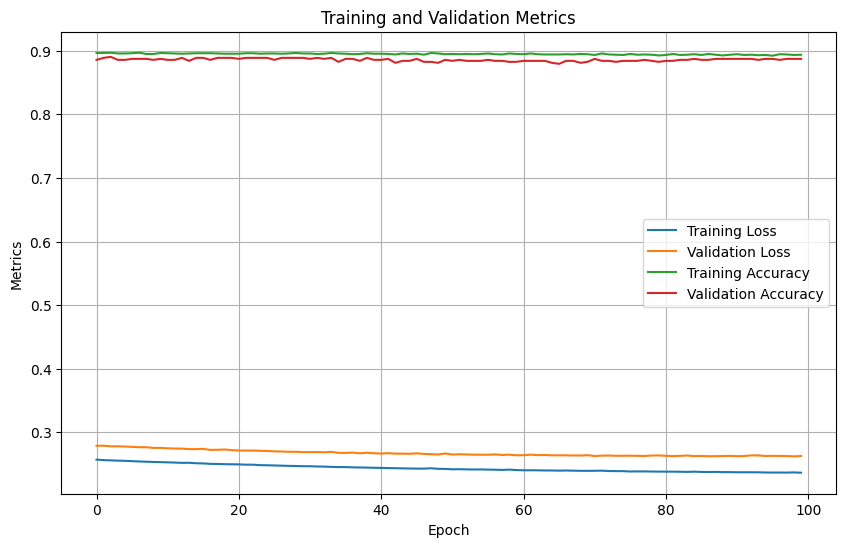

In [50]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
y_pred_proba = model2.predict(X_test)
y_pred_classes = (y_pred_proba > 0.5).astype(int)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [48]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93       340
         1.0       0.91      1.00      0.95       458

    accuracy                           0.94       798
   macro avg       0.95      0.93      0.94       798
weighted avg       0.95      0.94      0.94       798

